<a href="https://colab.research.google.com/github/ajay47847/MTP_SSL/blob/main/physionetalldata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Results:

Mean Accuracy Score: 81.39%
Mean Sensitivity (Recall): 0.50
Mean Specificity: 0.90
Mean Precision: 0.55
Mean F1 Score: 0.52
UAR: 0.70



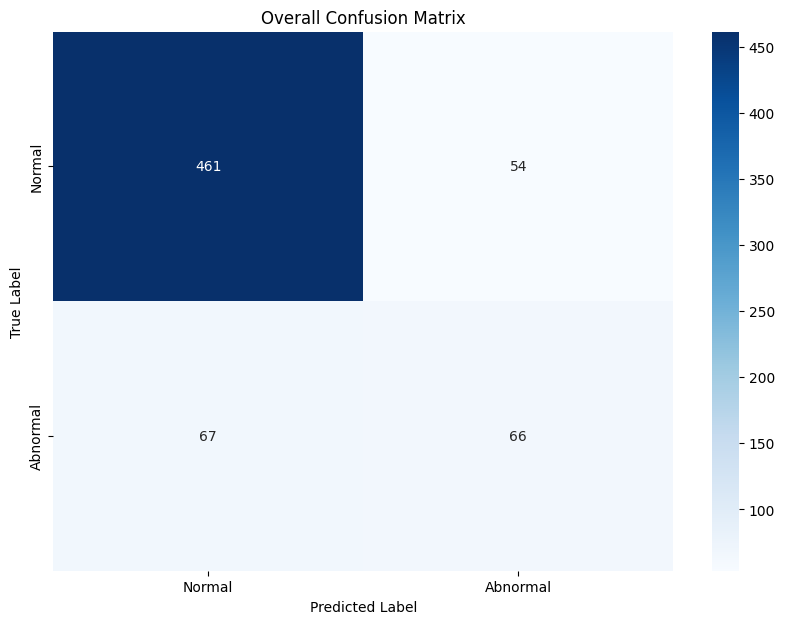

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Function to load audio files from a specified folder
def load_audio_files(file_list):
    audio_data = []
    record_names = []
    min_length = float('inf')
    for file_path in file_list:
        sr, y = wavfile.read(file_path)  # Load the audio file
        audio_data.append(y)
        record_name = os.path.splitext(os.path.basename(file_path))[0]  # Extract the record name
        record_names.append(record_name)
        min_length = min(min_length, len(y))
    # Trim all audio files to the minimum length
    audio_data = [audio[:min_length] for audio in audio_data]
    return np.array(audio_data), record_names, sr

# Function to normalize audio data using z-score
def z_score_normalize_audio_data(audio_data):
    normalized_audio = []
    for signal in audio_data:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        if std_val == 0:
            normalized_signal = signal - mean_val
        else:
            normalized_signal = (signal - mean_val) / std_val
        normalized_audio.append(normalized_signal)
    return np.array(normalized_audio)

# Function to extract features using Wav2Vec2.0
def extract_features_wav2vec(audio_data, processor, model, device):
    features = []
    for signal in audio_data:
        inputs = processor(signal, return_tensors='pt', sampling_rate=16000).input_values.to(device)
        with torch.no_grad():
            outputs = model(inputs).last_hidden_state
        features.append(outputs.squeeze(0).mean(dim=0).cpu().numpy())
    return np.array(features)

# Load the Excel file and process all sheets
excel_path = '/content/PMEA_37_12_2181_OnlineAppendix.xlsx'
sheets_dict = pd.read_excel(excel_path, sheet_name=None)

# Combine all sheets into a single DataFrame
df_combined = pd.concat(sheets_dict.values(), ignore_index=True)

# Normalize and prepare DataFrame
df_combined['Record name'] = df_combined['Record name'].str.strip().str.lower()

# Define the folder path containing the audio files
folder_path = '/content/drive/MyDrive/PCGtraining'
subfolders = sorted([f.path for f in os.scandir(folder_path) if f.is_dir()])

# Get a list of all .wav files in the subfolders in the desired order
audio_files = []
for subfolder in subfolders:
    audio_files.extend([os.path.join(subfolder, file) for file in os.listdir(subfolder) if file.endswith('.wav')])

# Load audio data
audio_data, record_names_loaded, sample_rate = load_audio_files(audio_files)

# Extract a fixed duration of audio (e.g., 5.0 seconds)
duration = 5.0
num_samples = int(duration * sample_rate)
audio_data = np.array([signal[:num_samples] for signal in audio_data])

# Z-normalize the audio data
audio_data_norm = z_score_normalize_audio_data(audio_data)

# Load Wav2Vec2.0 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Extract features using Wav2Vec2.0
features = extract_features_wav2vec(audio_data_norm, processor, model, device)

# Create a DataFrame for features with record names and types
df_features = pd.DataFrame(features)
df_features['Record Name'] = record_names_loaded

# Match 'Record Name' with 'Record name' in df_combined, using a lowercase, stripped comparison
df_features['Type (-1=normal 1=abnormal)'] = df_combined.set_index('Record name').loc[df_features['Record Name'].str.strip().str.lower()]['Type (-1=normal 1=abnormal)'].values

# Sort DataFrame by 'Record Name' in ascending order and reset index
df_features_sorted = df_features.sort_values(by='Record Name').reset_index(drop=True)

# # Print the sorted DataFrame
# print(df_features_sorted.to_string())

# Initialize the scaler for feature standardization
scaler = StandardScaler()

# Apply k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Separate features and labels
X = df_features_sorted.drop(columns=['Record Name', 'Type (-1=normal 1=abnormal)']).values
y = df_features_sorted['Type (-1=normal 1=abnormal)'].values

# d= pd.DataFrame(X)
# print(d.to_string())
# print(y)

# Fit the scaler on the data and transform
standardized_data = scaler.fit_transform(X)

# Store results for each fold
conf_matrices = []
accuracies = []
sensitivities = []
specificities = []
precisions = []
f1_scores = []

# Perform k-fold cross-validation manually
for train_index, test_index in kfold.split(standardized_data, y):
    X_train, X_test = standardized_data[train_index], standardized_data[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    precisions.append(precision)
    f1_scores.append(f1)

# Calculate and display the mean metrics
mean_accuracy = np.mean(accuracies)
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_precision = np.mean(precisions)
mean_f1_score = np.mean(f1_scores)
uar = (mean_sensitivity + mean_specificity) / 2

print()
print("Results:")
print()
print(f"Mean Accuracy Score: {mean_accuracy * 100:.2f}%")
print(f"Mean Sensitivity (Recall): {mean_sensitivity:.2f}")
print(f"Mean Specificity: {mean_specificity:.2f}")
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean F1 Score: {mean_f1_score:.2f}")
print(f"UAR: {uar:.2f}")

# Display the overall confusion matrix
overall_conf_matrix = np.mean(conf_matrices, axis=0)
print()
plt.figure(figsize=(10, 7))
sns.heatmap(overall_conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()